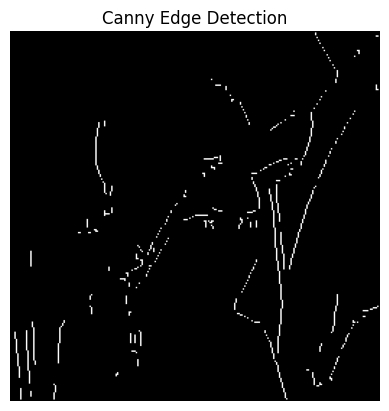

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Hàm Sobel cho phép tính đạo hàm theo chiều x và y
def sobel_filter(image):
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Bộ lọc Sobel theo chiều x
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])   # Bộ lọc Sobel theo chiều y

    Ix = ndimage.convolve(image, Gx)  # Đạo hàm theo chiều x
    Iy = ndimage.convolve(image, Gy)  # Đạo hàm theo chiều y

    magnitude = np.sqrt(Ix**2 + Iy**2)  # Độ lớn gradient
    direction = np.arctan2(Iy, Ix)     # Hướng gradient (tính theo radian)

    return magnitude, direction

# Hàm áp dụng non-maximum suppression (NMS)
def non_maximum_suppression(magnitude, direction):
    M, N = magnitude.shape
    output = np.zeros_like(magnitude)

    for i in range(1, M-1):
        for j in range(1, N-1):
            angle = direction[i, j] * 180.0 / np.pi
            angle = angle % 180

            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbor1 = magnitude[i, j+1]
                neighbor2 = magnitude[i, j-1]
            elif (22.5 <= angle < 67.5):
                neighbor1 = magnitude[i+1, j-1]
                neighbor2 = magnitude[i-1, j+1]
            elif (67.5 <= angle < 112.5):
                neighbor1 = magnitude[i+1, j]
                neighbor2 = magnitude[i-1, j]
            else:
                neighbor1 = magnitude[i-1, j-1]
                neighbor2 = magnitude[i+1, j+1]

            if (magnitude[i, j] >= neighbor1) and (magnitude[i, j] >= neighbor2):
                output[i, j] = magnitude[i, j]
            else:
                output[i, j] = 0

    return output

# Hàm áp dụng double thresholding
def double_thresholding(image, low_threshold, high_threshold):
    strong_edges = (image > high_threshold)
    weak_edges = (image >= low_threshold) & (image <= high_threshold)

    return strong_edges, weak_edges

# Hàm theo dõi các cạnh yếu
def edge_tracking(strong_edges, weak_edges):
    M, N = strong_edges.shape
    final_edges = strong_edges.copy()

    for i in range(1, M-1):
        for j in range(1, N-1):
            if weak_edges[i, j]:
                if np.any(strong_edges[i-1:i+2, j-1:j+2]):
                    final_edges[i, j] = 1

    return final_edges

# Hàm thực hiện bộ lọc Canny thủ công với Gaussian
def canny_edge_detection(image, low_threshold, high_threshold, sigma=1.4):
    smoothed_image = ndimage.gaussian_filter(image, sigma=sigma)

    # Áp dụng Sobel filter
    magnitude, direction = sobel_filter(smoothed_image)

    # Áp dụng non-maximum suppression
    nms_image = non_maximum_suppression(magnitude, direction)

    # Áp dụng double thresholding
    strong_edges, weak_edges = double_thresholding(nms_image, low_threshold, high_threshold)

    # Theo dõi các cạnh yếu
    final_edges = edge_tracking(strong_edges, weak_edges)

    return final_edges

def display_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

image = np.array(plt.imread('image.jpg'))
if len(image.shape) == 3:  
    image = np.mean(image, axis=2)

edges = canny_edge_detection(image, low_threshold=100, high_threshold=150)

display_image(edges, "Canny Edge Detection")

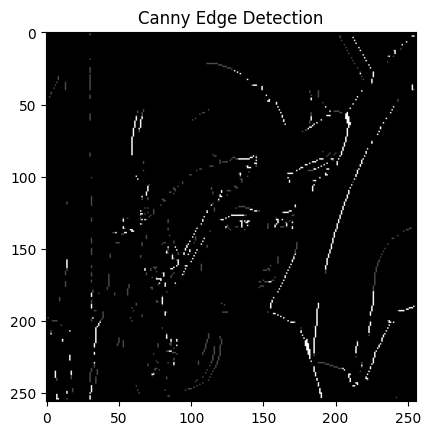

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve

# Bước 1: Chuyển ảnh về ảnh xám
def rgb2gray(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

# Bước 2: Bộ lọc Sobel để tính đạo hàm theo chiều x và y
def sobel_filter(img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    grad_x = convolve(img, sobel_x)
    grad_y = convolve(img, sobel_y)
    
    return grad_x, grad_y

# Bước 3: Tính độ lớn gradient và hướng
def gradient_magnitude_direction(grad_x, grad_y):
    magnitude = np.hypot(grad_x, grad_y)
    direction = np.arctan2(grad_y, grad_x) * 180.0 / np.pi
    direction[direction < 0] += 180
    return magnitude, direction

# Bước 4: Non-maximum suppression
def non_maximum_suppression(magnitude, direction):
    Z = np.zeros_like(magnitude)
    angle = direction / 180.0 * np.pi
    
    # Xử lý từng pixel trong ảnh
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            # Dự đoán hướng của pixel này
            q, r = 255, 255
            
            # Hướng 0 độ (ngang)
            if (0 <= angle[i, j] < np.pi / 8) or (15 * np.pi / 8 <= angle[i, j] < 2 * np.pi):
                q = magnitude[i, j + 1]
                r = magnitude[i, j - 1]
            # Hướng 45 độ (chéo phải dưới)
            elif (np.pi / 8 <= angle[i, j] < 3 * np.pi / 8):
                q = magnitude[i + 1, j - 1]
                r = magnitude[i - 1, j + 1]
            # Hướng 90 độ (dọc)
            elif (3 * np.pi / 8 <= angle[i, j] < 5 * np.pi / 8):
                q = magnitude[i + 1, j]
                r = magnitude[i - 1, j]
            # Hướng 135 độ (chéo trái dưới)
            elif (5 * np.pi / 8 <= angle[i, j] < 7 * np.pi / 8):
                q = magnitude[i - 1, j - 1]
                r = magnitude[i + 1, j + 1]

            # Kiểm tra xem pixel có phải là cực đại không
            if (magnitude[i, j] >= q) and (magnitude[i, j] >= r):
                Z[i, j] = magnitude[i, j]
            else:
                Z[i, j] = 0

    return Z

# Bước 5: Thresholding và edge tracking by hysteresis
def hysteresis_thresholding(img, low_threshold, high_threshold):
    strong_edges = (img > high_threshold)
    weak_edges = ((img >= low_threshold) & (img <= high_threshold))
    
    output = np.zeros_like(img, dtype=np.uint8)
    
    # Cảm nhận các cạnh mạnh và kết nối với các cạnh yếu
    output[strong_edges] = 255
    output[weak_edges] = 75
    
    return output

# Hàm main để xử lý ảnh
def canny_edge_detection(img, low_threshold, high_threshold):
    # Bước 1: Chuyển ảnh về ảnh xám và lọc nhiễu
    gray_img = rgb2gray(img)
    gray_img = ndimage.gaussian_filter(gray_img, sigma=1.4)

    # Bước 2: Tính gradient theo chiều x và y
    grad_x, grad_y = sobel_filter(gray_img)
    
    # Bước 3: Tính độ lớn gradient và hướng
    magnitude, direction = gradient_magnitude_direction(grad_x, grad_y)
    
    # Bước 4: Áp dụng non-maximum suppression
    suppressed_img = non_maximum_suppression(magnitude, direction)
    
    # Bước 5: Áp dụng thresholding và edge tracking by hysteresis
    edge_img = hysteresis_thresholding(suppressed_img, low_threshold, high_threshold)
    
    return edge_img

# Thử nghiệm với một ảnh mẫu
img = plt.imread('image.jpg')  # Thay đổi thành đường dẫn ảnh của bạn

# Chạy bộ lọc Canny
low_threshold = 100
high_threshold = 150
edge_image = canny_edge_detection(img, low_threshold, high_threshold)

# Hiển thị kết quả
plt.imshow(edge_image, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()


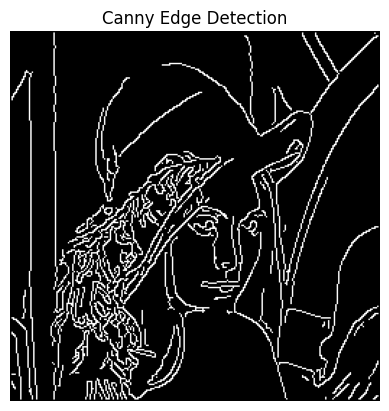

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
import scipy.misc as sm

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def load_data(file_names):    
    '''
    Load images from a list of image files
    Images are in JPG or PNG and we convert it to gray scale images
    '''
    imgs = []
    for filename in file_names:
        if os.path.isfile(filename):
            img = mpimg.imread(filename)
            img = rgb2gray(img)
            imgs.append(img)
    return imgs

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    
    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                    #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0

                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):
        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):
        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = ndimage.convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))  #dss
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

# Example usage
file_names = ['image.jpg'] 
imgs = load_data(file_names) 

# Create a Canny edge detector
canny_detector = cannyEdgeDetector(imgs, sigma=1, kernel_size=5)

# Perform edge detection on the images
edges = canny_detector.detect()[0]  # Get the first image result

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()


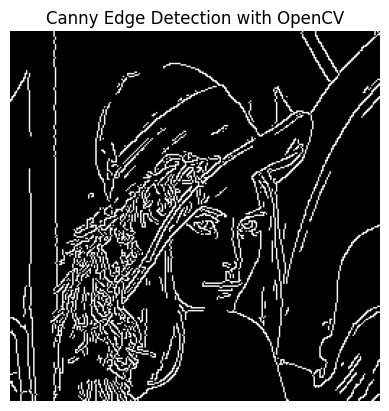

In [36]:
import cv2
import matplotlib.pyplot as plt

# Đọc ảnh
image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Áp dụng bộ lọc Canny của OpenCV
edges = cv2.Canny(image, threshold1=100, threshold2=150)

# Hiển thị kết quả
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection with OpenCV")
plt.axis('off')
plt.show()
